In [1]:
import os
import ogr
from shapely.wkt import loads as wktloads
import shapely
import utm_conversion as utm
import numpy as np
import shapely_tools as st
import pdb
from shapely.geometry import (Point, LineString, Polygon,
                              MultiLineString, MultiPoint, MultiPolygon, GeometryCollection)
from gdal_sample_points import gdal_sample_points
from collections import Counter
import osm2dh

In [2]:
# plot functions
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=3)

def plot_point(ax, ob, color='#000000'):
    x, y = ob.xy
    ax.plot(x, y, 'o', color=color, zorder=4, markersize=7)
    
def plot_bounds(ax, ob, color='#000000', marker='o'):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, marker, color=color, zorder=3)

def plot_line(ax, ob, color='red'):
    x, y = ob.xy
    ax.plot(x, y, color=color, alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2)
    

def baseplot(lines, title='', color='grey', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
    for line in lines:
        plot_line(ax, line, color)
        plot_bounds(ax, line, marker='.')
#         plot_coords(ax, line)       

In [3]:
# filter culverts, skip invalide fields and create gate objects
dataDir = r'd:\temp\CF1.2'
db_fn= os.path.join(dataDir, 'OSM', 'manzese_large-latest_v2.db')
dtm_fn = os.path.join(dataDir, 'DTM', 'manzese_DTM_0_5m_UTM37S_small.tif')

domain = shapely.geometry.Polygon([(524400, 9250200), (524400, 9247000), (526700, 9247000), (526700, 9250200)])
check_fields = {
    'width': float,
    'depth': float
}



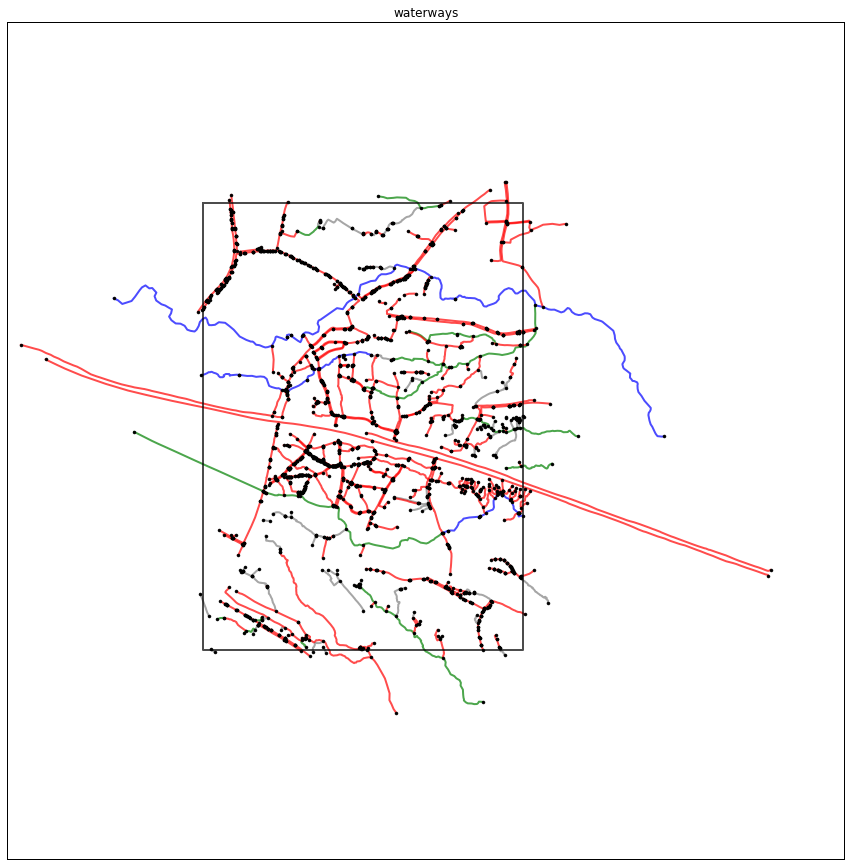

In [4]:
# filter features from OSM
geoms = {}
for val in ['ditch', 'stream', 'river', 'drain']:
    features = osm2dh.filter_features(db_fn, check_fields, bbox=domain, key='waterway', value=val, layer_index=1)
    geoms[val] = [feat['geometry'] for feat in features]
#     geoms[val] = st.clip_lines_with_polygon([feat['geometry'] for feat in features], domain.buffer(10))

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
colors = ['grey', 'blue', 'green', 'red']
for i, val in enumerate(geoms):
    baseplot(geoms[val], color=colors[i], ax=ax)
plot_line(ax, st.explode_polygons(domain)[0], color='black')
plt.axis('equal')
ax.set_title('waterways')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [7]:
values = ['ditch', 'stream', 'river', 'drain']
depths = [1., 1., 2., 0.5, 0.5]
widths = [1., 1., 5., 0.5, 0.5]
proftypes = [2, 2, 2, 2, 2]

objects = osm2dh.osm2channel(db_fn, check_fields, dtm_fn,
                      values, depths, widths, proftypes,
                      bbox=domain, bbox_buffer=10, max_snap_dist=10)

1149 lines filtered
line clipping done. 1149 lines
snapping + clipping done. 28 edits


In [5]:
objects[0].feature

{'geometry': <shapely.geometry.linestring.LineString at 0xe4eb9e8>,
 'properties': {'attr_edit': 1,
  'depth': 1.0,
  'geom_edit': 0,
  'id': '126187290',
  'name': 'channel126187290',
  'proftype': 2,
  'width': 1.0}}

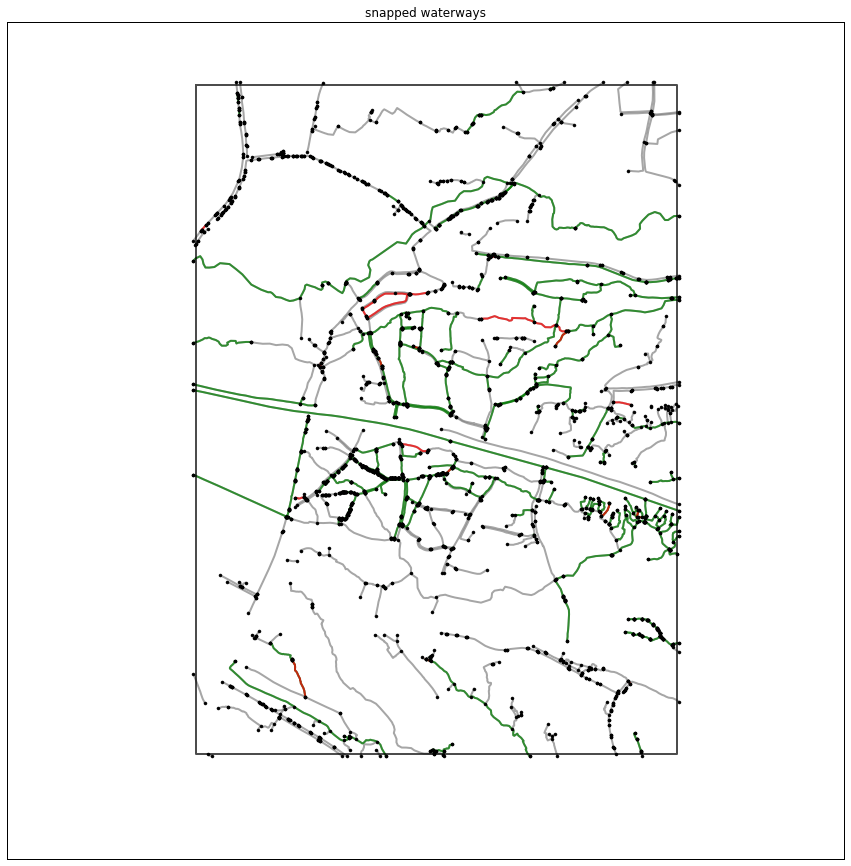

In [8]:
ww_all = [o.feature['geometry'] for o in objects]
ww_g_edited = [o.feature['geometry'] for o in objects if (o.feature['properties']['geom_edit'] == 1)]
ww_a_edited = [o.feature['geometry'] for o in objects if (o.feature['properties']['attr_edit'] == 1)]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
baseplot(ww_all, ax=ax)
baseplot(ww_a_edited, color='green', ax=ax)
baseplot(ww_g_edited, color='red', ax=ax)
plot_line(ax, st.explode_polygons(domain)[0], color='black')
plt.axis('equal')
ax.set_title('snapped waterways')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [ ]:
# # all wateyways
# features = filter_features(db_fn, check_fields, bbox=domain, key='waterway', value='', layer_index=1)
# geoms = [feat['geom'] for feat in features]
# print('{:d} lines filtered'.format(len(geoms)))
# ww_snapped, index, idx_snapped = snap_lines(geoms, max_dist=5, return_index=True)

# count_list = Counter(index).most_common(len(geoms))
# idx_clip = [idx for idx, count in count_list if count > 1]
# print('snapping + clipping done. {:d} edits'.format(len(idx_clip) + len(idx_snapped)))

In [ ]:
# # find edited lines
# ww_clipped = [geom for i,geom in enumerate(ww_snapped) if index[i] in idx_clip]
# ww_unchanged = [geom for i,geom in enumerate(ww_snapped) if  index[i] not in idx_clip]
# ww_edited = [geom for i,geom in enumerate(ww_snapped) if index[i] in idx_snapped]
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# baseplot(ww_unchanged, ax=ax)
# baseplot(ww_clipped, color='green', ax=ax)
# baseplot(ww_edited, color='red', ax=ax)
# plt.axis('equal')
# ax.set_title('snapped waterways')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)